In [1]:
pip install facenet-pytorch


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


In [5]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

/home/alejandro/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [6]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import os
workers = 0 if os.name == 'nt' else 4
import numpy as np
import cv2
from PIL import Image, ImageDraw
from IPython import display


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Running on device: cuda:0


In [8]:
mtcnn = MTCNN(
    image_size=128, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [9]:
import re
numbers = re.compile(r'(\d+)')

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def readLandmarks(landmarks_dir):
        os.chdir(landmarks_dir)
        # iteramos en los archivos
        with open('points_descr.info') as f:
            col_names=f.readlines()
            df=pd.DataFrame(columns=col_names)

        for file in sorted(os.listdir(), key=numericalSort):
            # Check whether file is in text format or not
            if file.endswith(".jpg") or file.endswith(".JPG"):
                image_file=file
            if file.endswith(".pts"):
                with open(file) as f:
                    lines=f.readlines()
                    
                count=0
                dataframe_row=[]
                for line in lines: 
                    count +=1
                    if(count >= 4 and count<=33):
                        vector=[int(i) for i in line.split()]
                        dataframe_row.append(vector)
                dataframe_row.append(image_file)
                df.loc[len(df)] = dataframe_row

        os.chdir('..')
        return df

                
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = readLandmarks(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 30])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 0:30]
        landmarks = np.array(landmarks)
        landmarks = np.array([np.array(x) for x in landmarks])
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    
            
            

0 (1024, 690, 3) (30, 2)


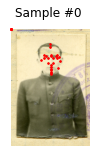

1 (1200, 782, 3) (30, 2)


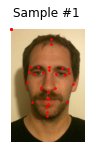

2 (1200, 852, 3) (30, 2)


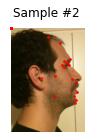

3 (1200, 1200, 3) (30, 2)


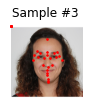

In [10]:
""""
face_dataset=FaceLandmarksDataset('./FORENSE_AM')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break
""""